In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from copy import deepcopy
from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display
from tqdm import tqdm
%matplotlib inline

In this notebook we get to know Pong environment from gym package and implement ES algorithm on it.

## 0. Pong Env

### 0.1. Environment discription

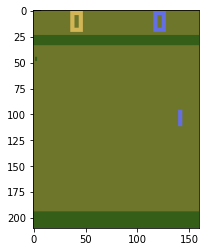

In [3]:
import gym

tmp_env = gym.make("PongDeterministic-v4")
tmp_env.reset()
plt.imshow(tmp_env.render('rgb_array'))

In [5]:
print("OBSERVATION SPACE: \n {}".format(tmp_env.observation_space.shape))
print("\n")
print("ACTION SPACE: \n {}".format(tmp_env.action_space))

OBSERVATION SPACE: 
 (210, 160, 3)


ACTION SPACE: 
 Discrete(6)


We see that each observation is given by a rgb image of shape (210, 160). 

At the same time, we have 6 actions:

1. 0,1 for standing 
2. 2,4 for moving left
3. 3,5 for moving right

In [13]:
state_size = tmp_env.observation_space.shape
n_actions = tmp_env.action_space.n

print("State size: {}".format(state_size))
print("Actions size: {}".format(n_actions))

State size: (210, 160, 3)
Actions size: 6


### 0.1. Interaction with environment

In [7]:
initial_state = tmp_env.reset()

print("NOW WE HAVE: \n")
print("Initial state is: {}".format(initial_state.shape))

#make step in environment
new_state, reward, done, _ = tmp_env.step(0)

print('\n')
print("AFTER ONE STEP WE GET: \n")

print("New state: {}".format(new_state.shape))
print("Reward: {}".format(reward))
print("The game is over? --  {}".format(done))

NOW WE HAVE: 

Initial state is: (210, 160, 3)


AFTER ONE STEP WE GET: 

New state: (210, 160, 3)
Reward: 0.0
The game is over? --  False


### 0.2 Random agent 

Before applying the ES algorithm lets look at perfomance of an agent which acts randomly.

In [8]:
class RandomAgent:
    def __init__(self, n_actions):
        self.n_actions = n_actions
    
    def get_action(self, state):
        return np.random.choice(self.n_actions)

### 0.3 Sessions display 

In [10]:
def display_session(env, agent, t_max = 500):
    """
    Displays an episode. 
    
    Args:
        env: gym environment
        agent: agent which interacts with environment
        t_max: trajectory length
    """
    plt.figure(figsize=(6, 5))
    display.clear_output(wait=True)
    
    
    total_reward = 0
    state = env.reset()
    
    for t in range(t_max):
        plt.gca().clear()
        
        action = agent.get_action(torch.tensor(state).float())
        new_state, reward, done, _ = env.step(action)
        state = new_state
        
        total_reward += reward
        
        plt.imshow(env.render('rgb_array'))

        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        if done:
            break
            
    return total_reward

Total reward: -11.0


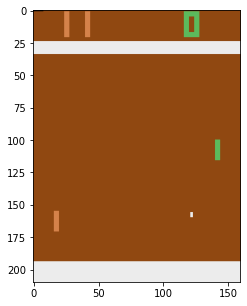

In [14]:
total_reward = display_session(tmp_env, RandomAgent(n_actions))
print('Total reward: {}'.format(total_reward))

### 0.4 Evaluation

In [15]:
def generate_session(env, agent, t_max=500):
    """
    Generates one session. 
    
    Args:
        env: gym environment
        agent: agent which interacts with environment
        t_max: trajectory length
        
    Returns:
        total_reward: total episode reward 
    """
    total_reward = 0
    state = env.reset()
    
    for t in range(t_max):
        action = agent.get_action(torch.tensor(state).float())
        new_state, reward, done, info = env.step(action)
        total_reward += reward
        state = new_state
        
        if done:
            break
            
    return total_reward


def score(env, agent, n=10, t_max=500):
    """
    Calculates total score for given number of generated sessions n and 
    length of trajectory t_max. 
    
    Args:
        env: gym environment
        agent: agent which interacts with environment
        n: number of generated session 
        t_max: trajectory length
    
    Returns:
        total_reward: average for all episodes reward
    """
    
    rewards = [generate_session(env, agent, t_max=t_max) for _ in range(n)]
    return sum(rewards) / n

In [16]:
n = 10
t_max = 500
reward = score(tmp_env, RandomAgent(n_actions), n, t_max)
print('Mean reward for {} games with random agent policy: {}'.format(n, total_reward))

Mean reward for 10 games with random agent policy: -11.0


### 0.5 Env preprocessing

In [23]:
import numpy as np
import gym
from gym.core import Wrapper
from gym.spaces.box import Box
import cv2

def make_pong():
    """Сreates breakout env with all preprocessing done for you"""
    return PreprocessAtari(gym.make("PongDeterministic-v0"))


class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42,
                 crop=lambda img: img[34:34 + 160], n_frames=4):
        """
        A gym wrapper that reshapes, crops and scales image into the desired shapes
        
        Args:
            env: gym environment
            height: height of the image 
            width: width of the image
            crop: function which crops big image
            n_frames: length of the buffer
        
        """
        super(PreprocessAtari, self).__init__(env)
        self.img_size = (height, width)
        self.crop = crop
        self.observation_space = Box(0.0, 1.0, [n_frames, height, width])
        self.framebuffer = np.zeros([n_frames, height, width])

    def reset(self):
        """Resets breakout, returns initial frames"""
        img = self.env.reset()
        x = self.preproc_image(img)[None, :]
        self.framebuffer = np.vstack((x, x, x, x))
        return self.framebuffer

    def step(self, action):
        """
        Plays breakout for 1 step, returns 4-frame buffer
        
        Args:
            action: action of an agent to make a step in environment
        """
        img, reward, done, info = self.env.step(action)
        self.update_buffer(img)
        return self.framebuffer, reward, done, info

    ###image processing###

    def update_buffer(self, img):
        """
        Updates buffer
        
        Args:
            img: image to add in buffer
        """
        self.framebuffer[1:] = self.framebuffer[0:-1]
        self.framebuffer[0] = self.preproc_image(img)

    def normalize_image(self, img):
        """
        Normalizes image
        
        img: image to scale
        """
        img_mn = img.mean()
        img_std = img.std()
        return (img - img_mn) / (img_std + 1e-3)


    def preproc_image(self, img):
        """
        What happens to the observation
        
        img: image to preprocess
        """
        img = self.crop(img)
        img = cv2.resize(src=img,
                       dsize=self.img_size,
                       interpolation=cv2.INTER_CUBIC).mean(-1)
        img = img.astype('float32') / 255.
        img = self.normalize_image(img)
        return img

In [24]:
env = make_pong()
print(env.observation_space.shape)

(4, 42, 42)


---

## 1. Evolution strategies

In [18]:
def add_noise_to_model(model, noise, copy=False):
    """
    Add noise to the parameters of our model (agent). 
    
    Args:
        model: maps the sates into the actions (i.e. agent)
        noise: noise which we add to parameters
        copy: whether to make a new copy of the model
    """
    if copy:
        new_model = deepcopy(model)
    else:
        new_model = model
        
    for param, noise_param in zip(new_model.parameters(), noise):
        param.data += noise_param

    return new_model

In [19]:
np.random.seed(2022)

In [37]:
class EvolutionStrategies:
    def __init__(self, get_env_function, lr=0.001, std=0.01, n_samples = 64, n_threads = 1, normalize=True, t_max=1e3):
        super().__init__()
        self.lr = lr
        self.std = std
        self.normalize = normalize
        self.n_samples = n_samples
        self.mean_reward_history = []
        self.n_threads = n_threads
        self.env = get_env_function()
        self.t_max = t_max
        
        
    def get_noised_model(self, model):
        """
        Generate noise and adds it to the model.
        
        Args:
            model: maps the sates into the actions (i.e. agent)
        
        Returns:
            model with noise and noise itself.
        """
        noise = []
        for param in model.parameters():
            noise.append(self.std * torch.randn(param.shape))
            
        return add_noise_to_model(model, noise, copy=True), noise
    
    def normalize_rewards(self, rewards):
        """
        Normalizes rewards. 
        
        Args:
            rewards: model rewards               
        """
        rewards = (rewards - torch.mean(rewards)) / torch.std(rewards)
        return rewards

    
    def optimize(self, model, noises, rewards):
        """
        Updates weights by adding the combined (weighted) noise. 
        
        Args:
            model: maps the sates into the actions (i.e. agent)
            noises: list of vectors of noises 
            rewards: rewards                
        """
        if self.normalize:
            rewards = self.normalize_rewards(rewards)
        
        combined_noise = []
        for i in range(len(list(model.parameters()))):
            cat_noise = torch.cat([n[i].unsqueeze(n[i].dim()) for n in noises], dim=-1)
            combined_noise.append(torch.sum(rewards * cat_noise / self.std, dim=-1))
            combined_noise[-1] *= self.lr / (len(noises) * self.std)

        add_noise_to_model(model, combined_noise)
    
    
    def step(self, model):
        """
        Calculates rewards and makes an optimizing step.
        
        Args:
            model: maps the sates into the actions (i.e. agent)
        """
        st = time.time()
        rewards = []
        noises = []
        noised_models = []
        for i in range(self.n_samples):
            noised_model, noise = self.get_noised_model(model)
            noised_models.append(noised_model)
            noises.append(noise)
        
        if self.n_threads == 1:
            rewards = [score(self.env, noised_models[i], t_max=self.t_max) for i in range(self.n_samples)]
        else:
            rewards = np.array(Parallel(n_jobs=self.n_threads)(delayed(score)(deepcopy(self.env), noised_models[i], t_max=self.t_max) 
                                                               for i in range(self.n_samples)))
        
        self.optimize(model, noises, torch.tensor(rewards))
        self.update_log(rewards)
        
    def update_log(self, rewards):
        """
        Logs new rewards.
        """
        mean_reward = np.mean(rewards)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards)
        plt.grid()

        plt.show()

In [32]:
class MLPPolicy(nn.Module):
    def __init__(self, state_size, actions):
        super(MLPPolicy, self).__init__()
        
        assert state_size == (4, 42, 42)

        self.actions = actions
        self.actions_size = len(actions)
        
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features = 4800, 
                      out_features = self.actions_size, 
                      bias=False)
        )
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=state_size[0], 
                      out_channels=3, 
                      kernel_size=3, 
                      bias=False),
            nn.Flatten()
        )
    

    def get_action(self, state):
        with torch.no_grad():
            state_after_convolution = self.conv_layers(state[None, :])
            final_state = self.linear_layers(state_after_convolution)
        
        return  self.actions[int(torch.argmax(final_state).numpy())]

In [33]:
n_states = env.observation_space.shape
print(n_states)
n_actions = env.action_space.n
print(n_actions)

(4, 42, 42)
6


In [34]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

last mean reward = -5.431


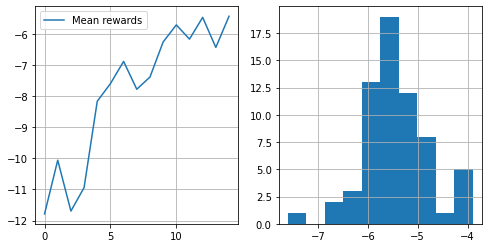

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [26:32<00:00, 106.16s/it]

102.07479286193848


In [39]:
model_500 = MLPPolicy(n_states, [1,2,3])

algorithm_500 = EvolutionStrategies(make_pong, std=0.01, lr=0.001, n_threads = -1, n_samples=64, normalize=True, t_max=500)

for i in tqdm(range(15)):
    t = time.time()
    algorithm_500.step(model_500)
    print(time.time() - t)

last mean reward = -15.188


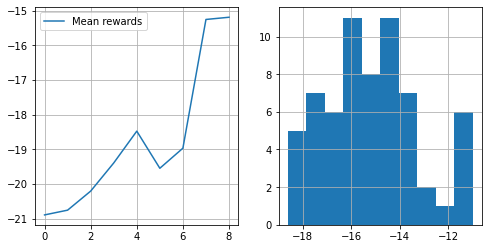

  4%|███████▎                                                                                                                                                           | 9/200 [35:50<15:09:54, 285.83s/it]

344.8697590827942


In [ ]:
model_5000 = MLPPolicy(n_states, [1,2,3])

algorithm_5000 = EvolutionStrategies(make_pong, std=0.01, lr=0.001, n_threads = -1, n_samples=64, normalize=True, t_max=5000)

for i in tqdm(range(200)):
    t = time.time()
    algorithm_5000.step(model_5000)
    print(time.time() - t)